# Importing the libraries

In [1]:
#Importing libraries
%tensorflow_version 1.x
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K
import os.path as osp
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive


# Reading and organizing data

In [2]:
#Read csv file
df0 = pd.read_csv('Colab Notebooks/data/final-15oct.csv')
test = pd.read_csv('Colab Notebooks/data/test_walk1.csv')
df0.head()

,TS,X,Y,Z,Activity
0,1570180005325,-1.540669,9.527725,-0.398635,DOWNSTAIRS
1,1570180005325,0.191536,9.439140,-0.568623,DOWNSTAIRS
2,1570180005334,0.678756,8.868123,0.367510,DOWNSTAIRS
3,1570180005353,0.531513,7.916428,0.332794,DOWNSTAIRS
4,1570180005374,0.705092,6.944382,0.111330,DOWNSTAIRS


In [0]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332728 entries, 0 to 332727
Data columns (total 5 columns):
TS          332728 non-null int64
X           332728 non-null float64
Y           332728 non-null float64
Z           332728 non-null float64
Activity    332728 non-null object
dtypes: float64(3), int64(1), object(1)
memory usage: 12.7+ MB


In [3]:
#Deal with empty values in train
def clean(df0):
  if((df0.isnull().any()).any()):
    print("Null values found")
    print(df.isnull().sum())
    df0.replace('',np.nan, inplace=True)
    df0=df0.dropna()
    print("Null droppped")
  else:
    print('No Null values')
  return df0
df0 = clean(df0)

No Null values


WALKING       148975
SITTING        79847
DOWNSTAIRS     63659
UPSTAIRS       40247
Name: Activity, dtype: int64
-------------------------------------


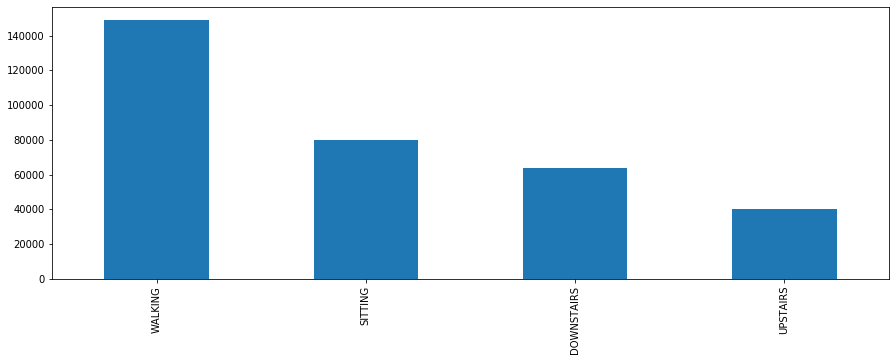

In [4]:
#visuaise records
val=df0['Activity'].value_counts()
print(val)
print('-------------------------------------')
plt.figure(figsize=(15,5))
val.plot(kind='bar')

In [0]:
#Split dataset into X and y
def split(df):
  X=df.iloc[:,1:4]
  y=df.iloc[:,4:5]
  X= X.astype(float)
  X= np.asarray(X)
  return X,y

#One Hot Encode Y
def ohe(y):
  y=pd.get_dummies(y)
  y= y.astype(int)
  y= np.asarray(y)
  return y

#Inverse One Hot Encoding
def de_ohe(y):
  deohe = np.array([])
  for i in y:
    n = np.argmax(i)
    if n == 3:
      deohe = np.append(deohe, ['WALKING'])
    elif n == 2:
      deohe = np.append(deohe, ['UPSTAIRS'])
    elif n == 1:
      deohe = np.append(deohe, ['SITTING'])
    elif n == 0:
      deohe = np.append(deohe, ['DOWNSTAIRS'])
  return deohe

#Standard Scale X
def scale(X):
  sc=StandardScaler()
  X=sc.fit_transform(X)
  return X

#Normalise X
def mmscale(X):
  mm = MinMaxScaler()
  mm.fit_transform(X)
  return X

#Makes no. samples per class equal
def symmetrify(df):
  unique = []
  df2 = pd.DataFrame()
  val = df['Activity'].value_counts()
  count = list(val)
  mini = min(count)
  for i in range(0,len(df)):
    act = df.at[i, 'Activity']
    if act not in unique:
      unique = unique + [act]
      df2 = df2.append(df.iloc[i : (i+mini), :])
  print(unique)
  print(df2['Activity'].value_counts())
  return df2, mini

#Create batches of data
def temporalize(ts, X, y):
    X_in=[]
    y_in=[]
    for i in range(ts, len(X), ts):
        n1 = X[i-ts:i,:]
        X_in.append(n1.tolist())
        if type(y) != int:
            n2=y[i-ts:i,:]
            y_in.append(n2.tolist())
    X_in=np.asarray(X_in ,dtype=np.float32)
    if type(y) != int:
        y_in=np.asarray(y_in, dtype=np.float32)
    return X_in, y_in

#Visualize history object
def visualize(history):
  plt.figure(figsize=(10,10))
  plt.subplot(2, 1, 1)
  plt.plot(history.history['loss'])
  plt.xlabel('EPOCH', color='w')
  plt.ylabel('LOSS' , color='w')
  plt.subplot(2, 1, 2)
  plt.plot(history.history['acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  return 0

In [6]:
df, mini = symmetrify(df0)

['DOWNSTAIRS', 'WALKING', 'UPSTAIRS', 'SITTING']
DOWNSTAIRS    40247
SITTING       40247
UPSTAIRS      40247
WALKING       40247
Name: Activity, dtype: int64


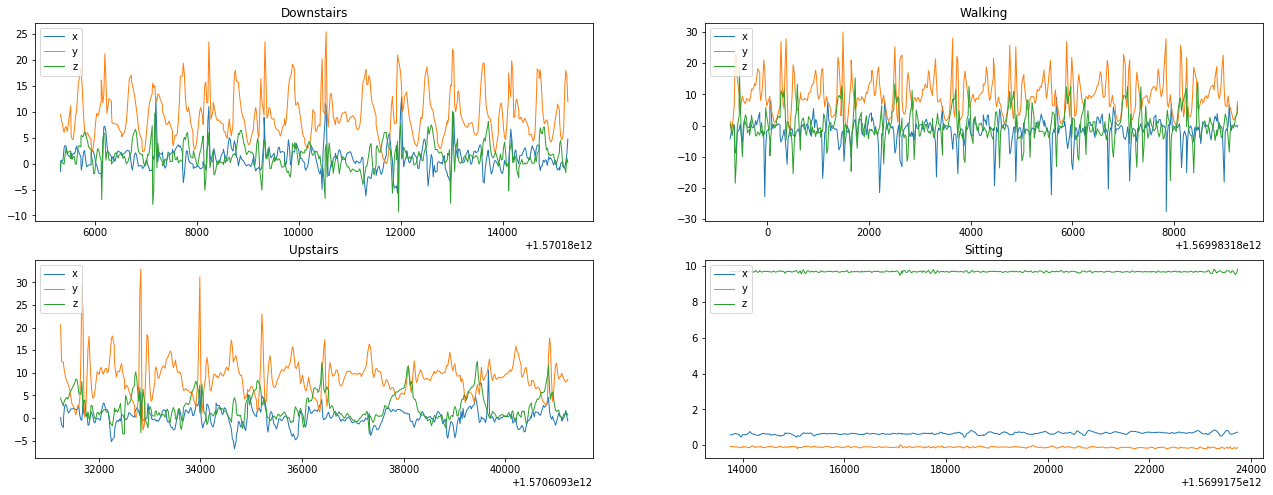

In [7]:
#plot of downstairs
a = 0
b = 500
fig, axes = plt.subplots(2, 2, figsize=(22, 8))
ts = df["TS"].iloc[0:500]
z= df["Z"].iloc[0:500]
y= df["Y"].iloc[0:500]
x= df["X"].iloc[0:500]
axes[0,0].plot(ts, x, lw=1)
axes[0,0].plot(ts, y, lw=1)
axes[0,0].plot(ts, z, lw=1)
axes[0,0].legend(['x', 'y', 'z'], loc='upper left')
axes[0,0].set_title("Downstairs")

#plot of walking
a = mini + 1
b = mini + 501
ts = df["TS"].iloc[a:b]
z= df["Z"].iloc[a:b]
y= df["Y"].iloc[a:b]
x= df["X"].iloc[a:b]
axes[0,1].plot(ts, x, lw=1)
axes[0,1].plot(ts, y, lw=1)
axes[0,1].plot(ts, z, lw=1)
axes[0,1].legend(['x', 'y', 'z'], loc='upper left')
axes[0,1].set_title("Walking")

#plot of upstairs
a = mini*2 + 1
b = mini*2 + 501
ts = df["TS"].iloc[a:b]
z= df["Z"].iloc[a:b]
y= df["Y"].iloc[a:b]
x= df["X"].iloc[a:b]
axes[1,0].plot(ts, x, lw=1)
axes[1,0].plot(ts, y, lw=1)
axes[1,0].plot(ts, z, lw=1)
axes[1,0].legend(['x', 'y', 'z'], loc='upper left')
axes[1,0].set_title("Upstairs")

#plot of sitting
a = mini*3 + 1
b = mini*3 + 501
ts = df["TS"].iloc[a:b]
z= df["Z"].iloc[a:b]
y= df["Y"].iloc[a:b]
x= df["X"].iloc[a:b]
axes[1,1].plot(ts, x, lw=1)
axes[1,1].plot(ts, y, lw=1)
axes[1,1].plot(ts, z, lw=1)
axes[1,1].legend(['x', 'y', 'z'], loc='upper left')
axes[1,1].set_title("Sitting")
plt.show()

In [0]:
X,y = split(df)

X_mm = mmscale(X)

y_ohe = ohe(y)

In [0]:
def temporalizetry(ts, X, y):
    X_in=[]
    y_in=[]
    for i in range(ts, len(X) - ts, 20):
        xs = X[i:i+ts,0:1]
        ys = X[i:i+ts,1:2]
        zs = X[i:i+ts,2:3]
        X_in.append([np.asarray(xs),np.asarray(ys),np.asarray(zs)])
        y_in.append(y[i].tolist())
    X_in=np.asarray(X_in ,dtype=np.float32)
    y_in=np.asarray(y_in, dtype = np.float32)
    return X_in, y_in

In [0]:
X_in, y_in=temporalizetry(70, X, y_ohe)
X_in = X_in.reshape(8043,70,3)

In [0]:
np.array(X_in).shape

(8043, 70, 3)

In [0]:
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X_in,y_in, test_size=0.2)

# Assemble the model

In [0]:
N_CLASSES = 4
N_HIDDEN_UNITS = 64
N_TIME_STEPS = 70
N_FEATURES = 3

In [0]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [0]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [0]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [0]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [0]:
N_EPOCHS = 5
BATCH_SIZE = 1024

In [21]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.7209447026252747 loss: 1.256098985671997

final results: accuracy: 0.9403356313705444 loss: 0.7730128765106201


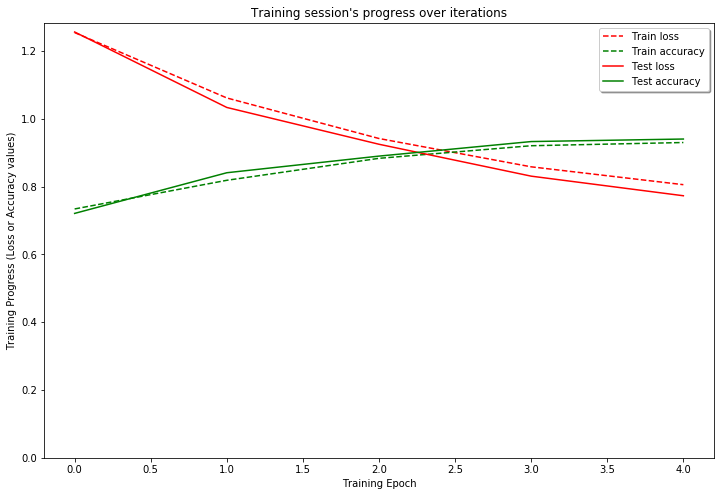

In [22]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [0]:
tf.train.write_graph(sess.graph_def, '.', './har.pbtxt')  
saver.save(sess, save_path = "./har.ckpt")
sess.close()

In [27]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = MODEL_NAME+'.pbtxt'
checkpoint_path = MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 70
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "Variable"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 64
          }
        }
        tensor_content: "\261(\307>\255x\n=<\006R?,\314\340\276\260\247\n\277\217\257\337=\003\326\216\277k\300%?\217\340\034\277\240\311\321>\222ES\277\250\264\234?u\313\371>DN\243>\336\352\244=6\021N>M\237\307\277;\247\006\276F\334D\277\225\340/?\214\350\321>-Y\217\275X\005\252\276]R\254?M\365\376\276\320\256f\277\346E\360\275\316\206\263\275E\006^?\357\361A\276X\327\

In [0]:
%tensorboard